In [1]:
!ls ../data/*.csv

../data/small_group_description.csv  ../data/train_target.csv
../data/test.csv		     ../data/transactions_test.csv
../data/test_ids_file.csv	     ../data/transactions_train.csv


# Data Preparation

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
import sys

In [4]:
from IPython.display import display

In [5]:
sys.path.append('../../../')

In [6]:
pd.options.display.float_format = '{:,.3f}'.format

In [7]:
df_trx = pd.concat([
    pd.read_csv('../data/transactions_train.csv'),
    pd.read_csv('../data/transactions_test.csv'),        
], axis=0)

In [8]:
df_trx.head()

,client_id,trans_date,small_group,amount_rur
0,33172,6,4,71.463
1,33172,6,35,45.017
2,33172,8,11,13.887
3,33172,9,11,15.983
4,33172,10,11,21.341


In [9]:
s_y = df_trx.groupby('trans_date')['amount_rur'].sum().sort_index()

In [10]:
assert (np.diff(s_y.index.values) == 1).all()

In [11]:
s_y

trans_date
0     1,122,959.265
1     2,563,636.431
2     2,824,431.548
3     2,851,063.215
4     2,865,754.323
           ...     
725   5,469,871.939
726   6,303,825.154
727   7,087,211.302
728   8,076,970.285
729   4,974,039.653
Name: amount_rur, Length: 730, dtype: float64

In [12]:
df_trx[lambda x: x['trans_date'] < 450] \
    ['small_group'].value_counts(normalize=True).cumsum()[lambda x: x <= 0.99].size

75

In [13]:
used_small_group = df_trx[lambda x: x['trans_date'] < 450]['small_group'].value_counts().index.tolist()[:70]

In [14]:
df_features = df_trx[lambda x: x['small_group'].isin(used_small_group)].pivot_table(
    index='trans_date',
    columns='small_group',
    values='amount_rur',
    aggfunc=[len, 'sum', 'std'],
).reindex(s_y.index).fillna(0)

In [15]:
# df_features = df_features.rolling(window=7).sum()

In [16]:
# df_features = df_features - df_features.ewm(alpha=0.2).mean()

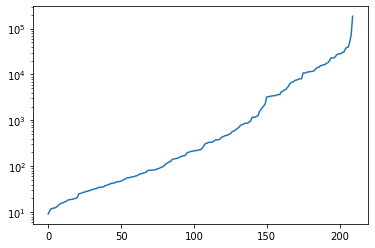

In [17]:
df_features.loc[:450].std().sort_values().reset_index(drop=True).plot(logy=True)
plt.show()

In [18]:
df_features = df_features / df_features.loc[:450].std()

In [19]:
df_features.shape

(730, 210)

In [20]:
df_features

len                                                           \
small_group    0      1     2      3     4     5     6     7     8      9     
trans_date                                                                    
0            0.189  2.846 2.294  9.812 1.975 2.824 2.022 0.321 0.670  2.087   
1            3.428  5.009 4.273  8.408 4.457 2.678 1.699 1.026 2.935  5.820   
2            4.140  5.547 4.756  8.263 4.551 3.173 2.427 1.347 3.337  6.574   
3            3.922  5.731 4.856  8.172 4.429 3.028 1.780 1.347 3.203  6.667   
4            3.719  5.819 4.943  7.971 4.326 3.726 2.508 0.834 3.423  6.742   
...            ...    ...   ...    ...   ...   ...   ...   ...   ...    ...   
725          7.060 10.667 6.228 10.549 8.075 5.764 4.126 5.708 3.885  9.526   
726          8.033 10.696 6.615 10.011 8.650 5.211 5.420 5.965 4.482  9.932   
727          9.863 10.954 8.144  9.604 9.285 5.298 6.229 5.580 6.139 11.132   
728         11.447 11.116 9.162  8.956 9.055 4.454 7.038 2.630 6.918 11.984   
729          7.176 10.115 5.792  9.580 7.342 3.814 4.369 1.860 4.141  9.279   

             ...   std                                                        
small_group  ...   76    77    78    80    82    83    91    106   109   115  
trans_date   ...                                                              
0            ... 2.303 0.489 1.817 0.151 1.970 0.308 0.314 0.385 1.577 0.196  
1            ... 0.636 1.162 1.525 1.760 0.271 2.076 0.361 0.417 0.641 0.696  
2            ... 0.355 0.527 0.758 0.203 0.977 0.745 0.456 1.058 0.357 0.206  
3            ... 0.621 0.711 1.311 0.288 0.662 0.575 0.459 0.674 0.327 0.114  
4            ... 0.371 0.633 1.930 0.407 0.411 0.578 0.483 0.617 0.497 0.490  
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
725          ... 1.416 1.932 1.964 0.213 2.244 1.550 2.184 2.182 0.092 0.408  
726          ... 0.512 5.181 1.225 2.174 1.079 0.877 0.749 0.871 0.090 0.583  
727          ... 0.586 5.741 1.562 0.509 2.053 0.888 0.569 5.353 0.078 0.623  
728          ... 0.532 1.393 1.840 2.434 1.495 0.716 0.590 0.906 2.735 0.710  
729          ... 0.396 1.369 1.301 3.750 0.372 0.929 0.356 1.476 0.284 0.741  

[730 rows x 210 columns]

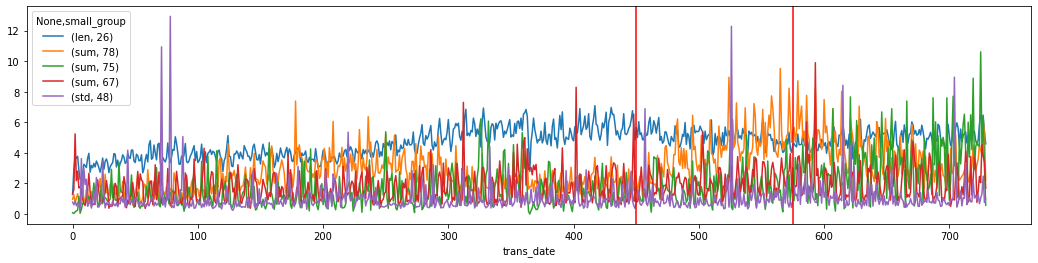

In [21]:
ix_rand_features = np.random.choice(df_features.shape[1], 5, replace=False)
df_features.iloc[:, ix_rand_features].plot(figsize=(18, 4))
plt.axvline(450, color='red')
plt.axvline(575, color='red')
plt.show()

# SE Debug

In [22]:
from dltranz.lightning_modules.stream_encoder import Loader3DTensor
from dltranz.lightning_modules.stream_encoder import TBatchNorm, TDropout, ClipRange, StreamEncoder

import torch
import pytorch_lightning as pl

In [38]:
import logging
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)

In [24]:
!rm -r lightning_logs/

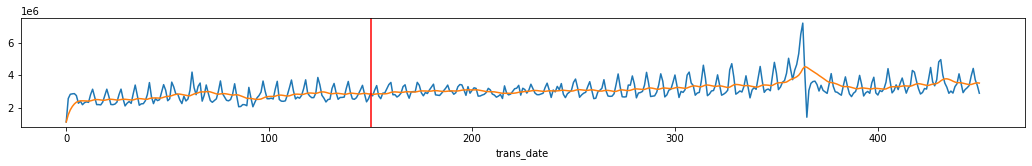

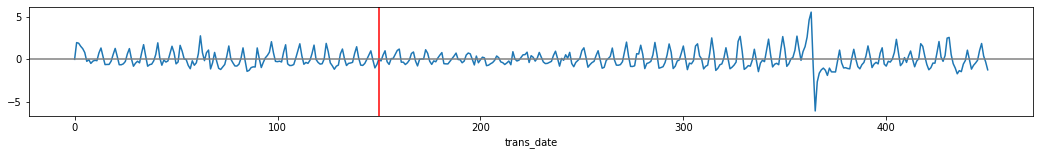

In [24]:
df_single_feature = s_y.loc[:450]
df_single_feature.plot(figsize=(18, 2))
df_single_feature.ewm(alpha=0.2).mean().ewm(alpha=0.2).mean().plot()
plt.axvline(150, color='red')
plt.show()
df_single_feature = (df_single_feature - 
                     df_single_feature.ewm(alpha=0.2).mean().ewm(alpha=0.2).mean()
                    )
df_single_feature = df_single_feature / df_single_feature.std()

df_single_feature.plot(figsize=(18, 2))
plt.axvline(150, color='red')
plt.axhline(0, color='gray')
plt.show()

In [25]:
agg_feature_encoder = torch.nn.Sequential(
#     TBatchNorm(1),
    ClipRange((-3, 3)),
    TDropout(0),
)

stream_encoder = StreamEncoder(
    encoder_x2z=agg_feature_encoder,
    history_size=14, predict_size=7, predict_lag=0,
    z_channels=1, c_channels=32,
    var_gamma_z=0.5, var_gamma_c=0.2,
    lr=0.001, weight_decay=4e-5,
    step_size=10, gamma=0.9,
    cpc_w=0.1,
    cov_z_w=0.1, var_z_w=1.0,
    cov_c_w=0.1, var_c_w=1.0,
)

In [26]:
l3dt = Loader3DTensor(stream_encoder)
dl_train = l3dt.get_train_dataloader(
    torch.from_numpy(df_single_feature.values.reshape(-1, 1)).unsqueeze(0).float()[:, 150:, :], 32, 4)
dl_valid = l3dt.get_valid_dataloader(
    torch.from_numpy(df_single_feature.values.reshape(-1, 1)).unsqueeze(0).float()[:, :150, :], 32, 0)
print(len(dl_train), len(dl_valid))
print(next(iter(dl_train))[0].shape, next(iter(dl_valid))[0].shape)

9 1
torch.Size([32, 21, 1]) torch.Size([1, 150, 1])


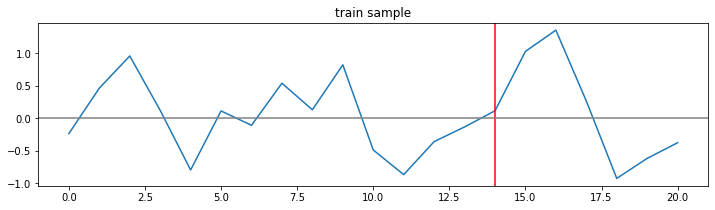

In [27]:
plt.figure(figsize=(12, 3))
plt.plot(next(iter(dl_train))[0][0][:, 0].numpy())
plt.axvline(stream_encoder.hparams.history_size, color='red')
plt.axhline(0, color='gray')
plt.title('train sample')
plt.show()

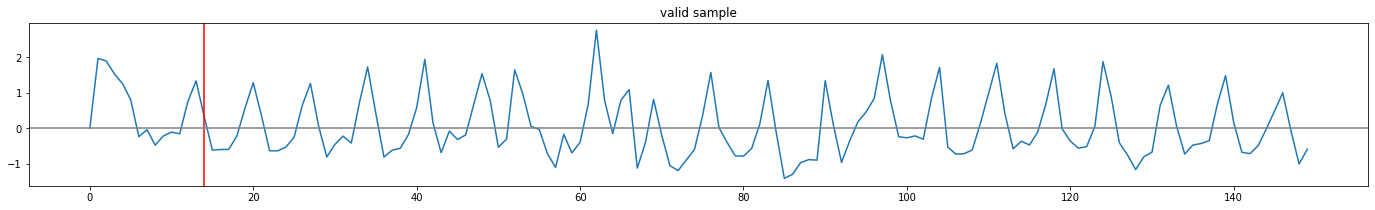

In [28]:
plt.figure(figsize=(24, 3))
plt.plot(next(iter(dl_valid))[0][0][:, 0].numpy())
plt.axvline(stream_encoder.hparams.history_size, color='red')
plt.axhline(0, color='gray')
plt.title('valid sample')
plt.show()

In [29]:
trainer = pl.Trainer(
    gpus=[3],
    max_epochs=100,
    log_every_n_steps=4,
    progress_bar_refresh_rate=50,  # weights_summary='full',
    logger=pl.loggers.TensorBoardLogger(
        save_dir='lightning_logs/',
        default_hp_metric=False,
    )
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [30]:
trainer.fit(stream_encoder, train_dataloader=dl_train, val_dataloaders=dl_valid)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name               | Type        | Params
---------------------------------------------------
0 | encoder_x2z        | Sequential  | 0     
1 | ar_rnn_z2c         | RNN         | 1.1 K 
2 | lin_predictors_c2p | ModuleList  | 231   
3 | reg_bn_z           | BatchNorm1d | 0     
4 | reg_bn_c           | BatchNorm1d | 0     
---------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/mnt2/kireev/pipenv_envs/pytorch-lifestream-bcSZKFyz/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [31]:
stream_encoder.eval()
with torch.no_grad():
    z, c = stream_encoder(torch.from_numpy(df_single_feature.values.reshape(-1, 1)).unsqueeze(0).float())
    p = [m(c) for m in stream_encoder.lin_predictors_c2p]

In [32]:
def torch_r2(y, p):
    return torch.where(
        y.var() * y.size(0) > 1e-6,
        1 - (y - p).pow(2).sum() / y.var() / y.size(0),
        torch.where(
            (y - p).pow(2).sum() > y.var() * y.size(0),
            torch.tensor([-1.0]),
            torch.tensor([0.0]),
        )
    )

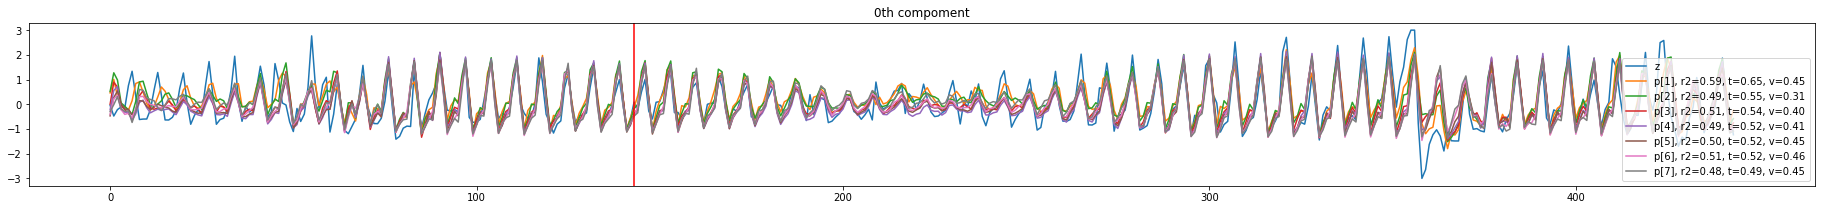

In [33]:
_, axs = plt.subplots(z.size(2), 1, figsize=(32, 3 * z.size(2)))
if z.size(2) == 1:
    axs = [axs]
for i, ax in zip(range(z.size(2)), axs):
    _z = z[0, len(p):, i]
    ax.plot(_z.numpy(), label='z')
    
    for j in range(len(p)):
        _p = p[j][0, len(p) - (j + 1):-(j + 1), i]
        r2_score = torch_r2(_z, _p)
        r2_train = torch_r2(_z[150 - len(p):], _p[150 - len(p):])
        r2_valid = torch_r2(_z[:150 - len(p)], _p[:150 - len(p)])
        ax.plot(_p.numpy(), label=', '.join([
            f'p[{j + 1}]',
            f'r2={r2_score.item():.2f}',
            f't={r2_train.item():.2f}',
            f'v={r2_valid.item():.2f}',
        ]))
    
    ax.set_title(f'{i}th compoment')
    ax.axvline(150 - len(p), color='red')
plt.legend()
plt.show()

# Stream Encoder

In [25]:
df_se_train = df_features.iloc[7:].loc[:450]

In [26]:
df_se_train

len                                                          \
small_group   0      1     2      3     4     5     6     7     8     9     
trans_date                                                                  
7           3.457  5.542 4.934  7.923 3.989 2.707 3.236 0.641 2.217 5.546   
8           3.530  6.353 3.868  9.519 5.581 3.901 2.265 1.988 1.328 5.573   
9           4.227  6.620 3.901  9.052 5.655 4.600 2.103 1.860 1.462 5.635   
10          3.806  6.733 4.027  8.958 5.562 4.774 1.780 2.501 1.778 6.164   
11          3.167  6.926 4.156  8.877 5.335 5.007 1.780 1.796 1.522 6.169   
...           ...    ...   ...    ...   ...   ...   ...   ...   ...   ...   
446         5.825 10.519 6.522 10.171 8.253 5.182 2.346 3.656 2.399 6.822   
447         7.742  9.985 6.708  8.684 7.403 4.687 2.912 3.592 3.934 7.413   
448         6.769  9.228 6.315  8.238 6.783 4.745 2.670 2.245 3.800 6.513   
449         5.055  9.508 5.273 10.398 8.236 6.899 2.508 3.912 1.827 5.992   
450         4.736  9.375 5.159 10.468 7.789 5.793 1.780 3.592 1.717 5.767   

             ...   std                                                        
small_group  ...   76    77    78    80    82    83    91    106   109   115  
trans_date   ...                                                              
7            ... 0.527 0.584 0.637 0.266 0.695 1.115 0.272 0.384 0.130 1.232  
8            ... 7.820 0.541 2.530 0.245 0.664 1.235 0.469 2.077 0.484 0.806  
9            ... 0.290 0.599 1.624 0.408 0.419 0.573 0.520 0.612 0.599 0.907  
10           ... 0.631 0.754 1.020 0.511 0.722 1.145 0.909 1.471 0.408 0.036  
11           ... 0.262 3.910 1.862 0.148 0.832 0.678 0.367 2.570 0.301 0.165  
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
446          ... 0.820 0.600 1.471 0.224 0.177 1.239 0.545 0.458 0.733 0.087  
447          ... 1.438 0.795 1.921 0.396 0.199 0.529 0.511 0.568 2.357 0.161  
448          ... 0.441 0.747 0.963 0.147 0.175 2.413 1.912 0.786 0.925 1.406  
449          ... 1.762 0.735 1.991 0.090 0.233 1.391 1.633 0.671 0.533 0.492  
450          ... 0.703 3.131 2.582 1.390 0.339 1.043 0.524 0.480 3.692 0.077  

[444 rows x 210 columns]

In [27]:
agg_feature_encoder = torch.nn.Sequential(
    TBatchNorm(210),
    ClipRange((-3, 3)),
    TDropout(0.3),
    torch.nn.Linear(210, 16),
)

stream_encoder = StreamEncoder(
    encoder_x2z=agg_feature_encoder,
    history_size=14, predict_size=12, predict_lag=7,
    z_channels=16, c_channels=32,
    var_gamma_z=0.5, var_gamma_c=0.2,
    lr=0.001, weight_decay=4e-5,
    step_size=10, gamma=0.9,
    cpc_w=0.1,
    cov_z_w=0.1, var_z_w=1.0,
    cov_c_w=0.1, var_c_w=1.0,
)

In [28]:
l3dt = Loader3DTensor(stream_encoder)
dl_train = l3dt.get_train_dataloader(torch.from_numpy(df_se_train.values).unsqueeze(0).float()[:, 150:, :], 32, 4)
dl_valid = l3dt.get_valid_dataloader(torch.from_numpy(df_se_train.values).unsqueeze(0).float()[:, :150, :], 32, 0)

In [29]:
print(len(dl_train), len(dl_valid))
print(next(iter(dl_train))[0].shape, next(iter(dl_valid))[0].shape)

9 1
torch.Size([32, 26, 210]) torch.Size([1, 150, 210])


In [30]:
trainer = pl.Trainer(
    gpus=[3],
    max_epochs=100,
    log_every_n_steps=4,
    progress_bar_refresh_rate=50, weights_summary=None,
    logger=pl.loggers.TensorBoardLogger(
        save_dir='lightning_logs/',
        default_hp_metric=False,
    )
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [31]:
trainer.fit(stream_encoder, train_dataloader=dl_train, val_dataloaders=dl_valid)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Missing logger folder: lightning_logs/default


Validation sanity check: 0it [00:00, ?it/s]

/mnt2/kireev/pipenv_envs/pytorch-lifestream-bcSZKFyz/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Tuning

In [32]:
def r_exp(b, m):
    a = b / m
    b = b * m
    a = np.log(a)
    b = np.log(b)
    
    return np.exp(np.random.random(1)[0] * (b - a) + a)

In [40]:
last_model = StreamEncoder.load_from_checkpoint(
    'lightning_logs/default/version_29/checkpoints/epoch=66-step=602.ckpt')

In [ ]:
mul_c = 1 + 2**4  # was 6
for i in range(20):
    params = dict(
        lr=r_exp(last_model.hparams.lr, mul_c),
        cov_z_w=r_exp(last_model.hparams.cov_z_w, mul_c),
        var_z_w=r_exp(last_model.hparams.var_z_w, mul_c),
        cov_c_w=r_exp(last_model.hparams.cov_c_w, mul_c),
        var_c_w=r_exp(last_model.hparams.var_c_w, mul_c),
    )
    print(f'[{i:04d}] - start', end='')
    stream_encoder = StreamEncoder(
        **{k: v for k, v in last_model.hparams.items() if k in (
            'history_size', 'predict_size', 'predict_lag',
            'var_gamma_z', 'var_gamma_c', 'step_size', 'gamma',
            'z_channels', 'c_channels',
            'weight_decay',
            'cpc_w',
        )},
        encoder_x2z=torch.nn.Sequential(
            TBatchNorm(210),
            ClipRange((-3, 3)),
            TDropout(0.3),
            torch.nn.Linear(210, 16),
        ),
        **params,
    )
    pl.Trainer(
        gpus=[3],
        max_epochs=500,
        log_every_n_steps=4,
        progress_bar_refresh_rate=0, weights_summary=None,
        logger=pl.loggers.TensorBoardLogger(
            save_dir='lightning_logs/',
            default_hp_metric=False,
        ),
        callbacks=[
            pl.callbacks.EarlyStopping(monitor='hp/cpc_pow', mode='max', patience=10, min_delta=0.0)
        ],
    ).fit(stream_encoder, train_dataloader=dl_train, val_dataloaders=dl_valid)
    print(' - done')

[0000] - start

/mnt2/kireev/pipenv_envs/pytorch-lifestream-bcSZKFyz/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


 - done
[0001] - start - done
[0002] - start - done
[0003] - start - done
[0004] - start - done
[0005] - start - done
[0006] - start - done
[0007] - start - done
[0008] - start - done
[0009] - start - done
[0010] - start - done
[0011] - start - done
[0012] - start - done
[0013] - start - done
[0014] - start - done
[0015] - start - done
[0016] - start - done
[0017] - start

In [ ]:
from copy import deepcopy

In [ ]:
last_model = deepcopy(stream_encoder)

In [ ]:
!rm -r ligh

In [ ]:
for i in range(100):
    params = dict(
        is_batch_norm=np.random.choice([False, True], 1)[0],
        is_tanh=np.random.choice([False, True], 1)[0],
        p_dropout=0 if np.random.random() < 0.1 else np.random.random(1)[0],
    )
    print(f'[{i:04d}] - start', end='')
    stream_encoder = StreamEncoder(
        **{k: v for k, v in last_model.hparams.items() if k in (
            'history_size', 'predict_size', 'predict_lag', 'in_channels', 'clip_range',
            'var_gamma_z', 'var_gamma_c', 'step_size', 'gamma',
            'h_channels', 'z_channels', 'c_channels',
            'weight_decay',
            'cpc_w', 'lr', 'cov_z_w', 'var_z_w', 'cov_c_w', 'var_c_w',
        )},
        x_dropout=0.2,
        **params,
    )
    pl.Trainer(
        gpus=[3],
        max_epochs=500,
        log_every_n_steps=4,
        progress_bar_refresh_rate=0, weights_summary=None,
        logger=pl.loggers.TensorBoardLogger(
            save_dir='lightning_logs/',
            default_hp_metric=False,
        ),
        callbacks=[
            pl.callbacks.EarlyStopping(monitor='hp/cpc_pow', mode='max', patience=10, min_delta=0.0)
        ],
    ).fit(stream_encoder, train_dataloader=dl_train, val_dataloaders=dl_valid)
    print(' - done')

# Eval

In [ ]:
model = StreamEncoder.load_from_checkpoint('lightning_logs/default/version_120/checkpoints/epoch=129-step=1169.ckpt')
print(model.hparams)

In [ ]:
pred_horizon = 10
model.eval()
with torch.no_grad():
    data_norm, z, c = model(torch.from_numpy(df_se_train.values).unsqueeze(0).float()[:, :, :])
    p = model.lin_predictors_c2p[pred_horizon - 1 - model.hparams.predict_lag](c)

In [ ]:
data_norm, z, c, p = [t for t in [data_norm, z, c, p]]

a = data_norm[0].detach().numpy()
plt.figure(figsize=(16, 16 * a.shape[1] / a.shape[0]))
plt.imshow(np.clip(a, *np.quantile(a, [0.05, 0.95], axis=0)).T)
plt.title('x')
plt.show()

a = z.unsqueeze(-1).repeat(1, 1, 1, 2).view(*z.size()[:-1], -1)[0].detach().numpy()
plt.figure(figsize=(16, 16 * 2 * a.shape[1] / a.shape[0]))
plt.imshow(a.T)
plt.title('z')
plt.show()

a = p.unsqueeze(-1).repeat(1, 1, 1, 2).view(*z.size()[:-1], -1)[0].detach().numpy()
plt.figure(figsize=(16, 16 * 2 * a.shape[1] / a.shape[0]))
plt.imshow(a.T)
plt.title('p')
plt.show()

a = c.unsqueeze(-1).repeat(1, 1, 1, 2).view(*z.size()[:-1], -1)[0].detach().numpy()
plt.figure(figsize=(16, 16 * 2 * a.shape[1] / a.shape[0]))
plt.imshow(a.T)
plt.title('c')
plt.show()

_, axs = plt.subplots(4, 1, figsize=(16, 5 * 4))
axs[0].plot(data_norm[0].detach().numpy())
axs[0].set_title('x signal')
axs[1].plot(z[0].detach().numpy())
axs[1].set_title('z signal')
axs[2].plot(p[0].detach().numpy())
axs[2].set_title('p signal')
axs[3].plot(c[0].detach().numpy())
axs[3].set_title('c signal')
plt.show()


_, axs = plt.subplots(z.size(2), 1, figsize=(16, 3 * z.size(2)))
for i, ax in zip(range(z.size(2)), axs):
    ax.plot(z[0, pred_horizon:, i].detach().numpy())
    ax.plot(p[0, :-pred_horizon, i].detach().numpy())
    r2_score = torch.where(
        z[0, 7 + pred_horizon:, i].var() * (z.size(1) - pred_horizon) > 1e-6,
        1 - (z[0, pred_horizon:, i] - p[0, :-pred_horizon, i]).pow(2).sum() / 
            z[0, pred_horizon:, i].var() / (z.size(1) - pred_horizon),
        torch.tensor([0.0]),
    )
    ax.set_title(f'{i}th compoment. r2={r2_score.item():.3f}')
plt.show()

r2_score = torch.where(
    z[:, pred_horizon:, :].var(dim=1) / (z.size(1) - pred_horizon) > 1e-6,
    1 - (z[:, pred_horizon:] - p[:, :-pred_horizon]).pow(2).sum(dim=1) / 
        z[:, pred_horizon:, :].var(dim=1) / (z.size(1) - pred_horizon),
    torch.tensor([0.0]),
)
print(f'r2_score = {r2_score.mean():.3f}')

_z = (z - z.mean(dim=1, keepdims=True)) / (z.std(dim=1, keepdims=True) + 1e-6)
mc = torch.bmm(_z.transpose(1, 2), _z).abs() / _z.size(1)
C = mc.size(1)
off_diag_ix = (1 - torch.eye(C)).bool().view(-1)
m = mc.view(-1, C * C)[:, off_diag_ix].mean()
print(f'z_self_corr = {m:.3f}')
print(f'z_unique_features = {1 / (mc.mean() + 1e-3):.3f}', )
print(f'cpc_pow = {r2_score.mean() / (mc.mean() + 1e-3):.3f}')

# Inference

In [ ]:
model.eval()
with torch.no_grad():
    x, z, c = model(torch.from_numpy(df_features.fillna(df_features.mean()).values).float().unsqueeze(0))

In [ ]:
df_se_x = pd.DataFrame(x[0].numpy(), index=df_features.index)
df_se_z = pd.DataFrame(z[0].numpy(), index=df_features.index)
df_se_c = pd.DataFrame(c[0].numpy(), index=df_features.index)

# Downstream task

In [ ]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

In [ ]:
[t.shape for t in [df_features, df_se_x, df_se_z, df_se_c]]

### target

In [ ]:
predict_to_future=1
s_all_targets = s_y.rolling(window=predict_to_future).sum().shift(-predict_to_future)

In [ ]:
s_all_targets

In [ ]:
pd.concat([
    s_y.rename('amounts'),
    s_all_targets.rename('target'),
], axis=1).plot(figsize=(18, 4), secondary_y='target')
plt.axvline(450, color='red')
plt.axvline(575, color='red')
plt.show()

In [ ]:
np.log1p(s_all_targets).hist()
plt.show()

In [ ]:
ix_train = s_all_targets.loc[:450].index[28:]
ix_valid = s_all_targets.loc[450+1:575].index
ix_test = s_all_targets.loc[575+1:].index[:-7]
ix_all = s_all_targets.index[28:-7]

(ix_train, ix_valid, ix_test, ix_all)

In [ ]:
s_all_targets.plot(figsize=(18, 4))
s_y.rolling(window=predict_to_future).sum().ewm(alpha=0.1).mean().ewm(alpha=0.05).mean().plot()
plt.show()

In [ ]:
def train_estimate(model_cls, model_params, X, name):
    model = model_cls(**model_params)
    
    x_train = X.reindex(ix_train).values
    x_mean = x_train.mean(axis=0, keepdims=True)
    x_std = x_train.std(axis=0, keepdims=True)  
    x_std = np.where(x_std < 1, 1, x_std)

    y_mean = s_y.rolling(window=predict_to_future).sum().ewm(alpha=0.1).mean().ewm(alpha=0.05).mean()
    y_std = (s_all_targets - y_mean).reindex(ix_train).values.std()

    model.fit(
        (X.reindex(ix_train).values - x_mean) / x_std, 
        (s_all_targets - y_mean).reindex(ix_train).values / y_std,
    )
    
    s_predict = pd.Series(
        model.predict((X.reindex(ix_all).values - x_mean) / x_std) * y_std,
        index=ix_all,
    ) + y_mean
    df_all_predict = pd.concat([
        s_all_targets.rename('y_true'),
        s_predict.rename('y_predict'),
    ], axis=1)

    
    pd_results = pd.concat([
        df_all_predict.reindex(ix).groupby(lambda x: name).apply(
            lambda x: pd.Series([
                r2_score(x['y_true'], x['y_predict']),
                mean_absolute_percentage_error(x['y_true'], x['y_predict']),
                mean_squared_error(x['y_true'], x['y_predict'], squared=False),
            ], index=['r2', 'mape', 'rmse']))
        for ix, name in zip([ix_train, ix_valid, ix_test], ['train', 'valid', 'test'])
    ]).unstack().rename(name).to_frame().T
    display(pd_results)

    ax = df_all_predict.plot(figsize=(18, 2))
    for x in [21, 450, 575, len(s_y) - 7]:
        ax.axvline(x, color='red')
    plt.show()
    
    return pd_results

In [ ]:
class DummyModel:
    def fit(self, X, y):
        return self
    
    def predict(self, X):
        return np.zeros(len(X))

In [ ]:
all_results = []

In [ ]:
all_results.append(train_estimate(DummyModel, {}, pd.concat([
    *[s_y.shift(i) for i in range(1)],
], axis=1), 'dummy'))
all_results.append(train_estimate(Ridge, dict(alpha=1), pd.concat([
    *[s_y.shift(i) for i in range(7)],
], axis=1), 'ar7'))
all_results.append(train_estimate(Ridge, dict(alpha=1), pd.concat([
    *[s_y.shift(i) for i in range(14)],
], axis=1), 'ar14'))
all_results.append(train_estimate(Ridge, dict(alpha=1), pd.concat([
    *[s_y.shift(i) for i in range(21)],
], axis=1), 'ar21'))

In [ ]:
all_results.append(train_estimate(Ridge, dict(alpha=300), pd.concat([
    *[s_y.shift(i) for i in range(14)],
    *[df_features.shift(i) for i in range(1)],
], axis=1), 'ar14+f1'))

In [ ]:
all_results.append(train_estimate(Ridge, dict(alpha=300), pd.concat([
    *[s_y.shift(i) for i in range(14)],
    *[df_se_x.shift(i) for i in range(1)],
], axis=1), 'ar14+x1'))

In [ ]:
all_results.append(train_estimate(Ridge, dict(alpha=70), pd.concat([
    *[s_y.shift(i) for i in range(14)],
    *[df_se_z.shift(i) for i in range(1)],
], axis=1), 'ar14+z1'))

In [ ]:
all_results.append(train_estimate(Ridge, dict(alpha=50), pd.concat([
    *[s_y.shift(i) for i in range(14)],
    *[df_se_c.shift(i) for i in range(1)],
], axis=1), 'ar14+c1'))

In [ ]:
m_list = pd.concat(all_results, axis=0).columns.levels[0]
e_list = pd.concat(all_results, axis=0).index
e_lists = [
    ['ar14', 'ar14+f1'],
    ['ar14', 'ar14+x1'],
    ['ar14', 'ar14+z1'],
    ['ar14', 'ar14+c1'],
]

_, axs = plt.subplots(1 + len(e_lists), len(m_list), figsize=(6 * len(m_list), 3 * (1 + len(e_lists))))
for ax, m in zip(axs[0], m_list):
    pd.concat(all_results, axis=0).stack(level=1).swaplevel().unstack()[m][e_list] \
    .plot(kind='bar', ax=ax, title=m)
for l, _axs in zip(e_lists, axs[1:]):
    for ax, m in zip(_axs, m_list):
        pd.concat(all_results, axis=0).stack(level=1).swaplevel().unstack()[m][l] \
        .plot(kind='bar', ax=ax, title=m, legend=None)
plt.show()